Dense Neural Network for cattle weight gain

INSTITUTO FEDERAL DE MINAS GERIAS Departamento de Engenharia e Computação

Professor: Ciniro Nametala

Aluno: Euler Gomes e Daniel Reis

# 1. Ambient preparation

In [281]:
from IPython.display import display, HTML
from torchsummary import summary

display(HTML("<style>.container {widht: 100% !important;}</style>"))

## 1.1. Import packages

In [282]:
import subprocess
import sys
import os

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

## 1.2. Export requirements

In [283]:
def export_requirements():
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "freeze"],
                                capture_output=True,
                                text=True,
                                check=True)
        with open('requirements.txt', 'w') as f:
            f.write(result.stdout)
        print('requirements.txt file generated successfully.')
    except subprocess.CalledProcessError as e:
        print('error:', e)


export_requirements()

requirements.txt file generated successfully.


## 1.3. GPU check

In [284]:
if torch.cuda.is_available():
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("Device Name:", torch.cuda.get_device_name(0))
    device = 'cuda'
else:
    print("CUDA is not available.")
    device = 'cpu'

print('Device:', device)

__CUDNN VERSION: 91200
Device Name: NVIDIA GeForce RTX 5070
Device: cuda


## 1.4. Experiment configuration

In [285]:
new_model: True

# 2. Load dataset

In [286]:
data = pd.read_csv('data/cattle_gain.csv')

target = "saida_gmd_kg_dia"
col_names = data.columns.values.tolist()

print(col_names)
data.head()

['sexo', 'raca', 'idade_dias', 'peso_inicial_kg', 'qualidade_pasto', 'tipo_pasto', 'taxa_lotacao_ua_ha', 'area_pasto_ha_animal', 'quantidade_suplemento_kg_dia', 'suplementacao_acesso_livre', 'evento_sanitario_recente', 'tipo_evento_sanitario', 'vermifugacao_recente', 'vacina_recente', 'tratamento_recente', 'temperatura_media', 'estacao_ano', 'rotacao_piquete', 'condicao_corporal', 'tipo_suplementato', 'frequencia_suplementacao_semana', 'facilidade_acesso_agua', 'severidade_evento', 'estresse_transporte', 'estresse_manejo', 'dias_evento_sanitario', 'tipo_sistema_manejo', 'dias_permanecia', 'tipo_fonte_agua', 'saida_ganho_total_kg', 'saida_gmd_kg_dia']


,sexo,raca,idade_dias,peso_inicial_kg,qualidade_pasto,tipo_pasto,taxa_lotacao_ua_ha,area_pasto_ha_animal,quantidade_suplemento_kg_dia,suplementacao_acesso_livre,...,facilidade_acesso_agua,severidade_evento,estresse_transporte,estresse_manejo,dias_evento_sanitario,tipo_sistema_manejo,dias_permanecia,tipo_fonte_agua,saida_ganho_total_kg,saida_gmd_kg_dia
0,F,anelorada,620,185,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,381,poco_artesiano,126,0.330709
1,F,anelorada,620,168,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,450,poco_artesiano,148,0.328889
2,F,anelorada,620,153,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,450,poco_artesiano,143,0.317778
3,F,anelorada,620,130,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,450,poco_artesiano,211,0.468889
4,F,anelorada,620,156,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,450,poco_artesiano,154,0.342222


## 2.1. Separate x and y from data

In [287]:
cols_to_drop = [
    "saida_ganho_total_kg",  # se existir
]
data = data.drop(columns=[c for c in cols_to_drop if c in data.columns])

x = data.drop(columns=target)
y = data[target]

print(y.head())

0    0.330709
1    0.328889
2    0.317778
3    0.468889
4    0.342222
Name: saida_gmd_kg_dia, dtype: float64


## 2.2. Data exploration

In [288]:
data.describe()

,idade_dias,peso_inicial_kg,taxa_lotacao_ua_ha,area_pasto_ha_animal,quantidade_suplemento_kg_dia,temperatura_media,frequencia_suplementacao_semana,dias_permanecia,saida_gmd_kg_dia
count,204.000000,204.000000,204.0,204.000000,204.000000,204.000000,204.0,204.000000,204.000000
mean,547.901961,177.014706,1.0,1.089496,0.877461,26.377451,7.0,378.362745,0.311916
std,78.962236,49.341724,0.0,0.217343,0.226959,4.024516,0.0,178.078180,0.136307
min,384.000000,25.000000,1.0,0.857143,0.248000,20.000000,7.0,43.000000,-0.186047
25%,530.000000,140.000000,1.0,0.900000,0.785250,23.000000,7.0,264.250000,0.257327
50%,530.000000,178.000000,1.0,0.900000,0.916500,24.000000,7.0,375.000000,0.334692
75%,530.000000,208.000000,1.0,1.333333,1.047000,31.000000,7.0,465.000000,0.391740
max,890.000000,306.000000,1.0,1.333333,1.623000,31.000000,7.0,933.000000,0.819149


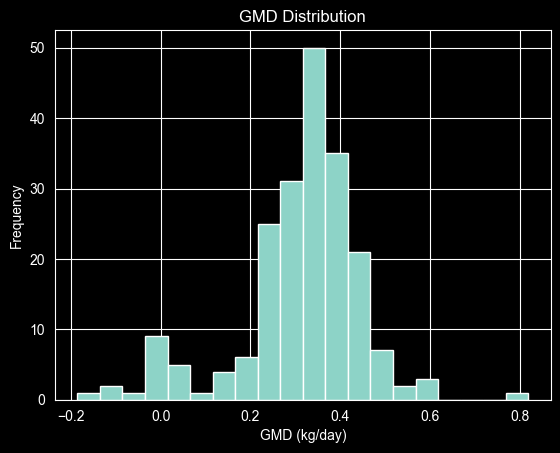

In [289]:
plt.hist(data["saida_gmd_kg_dia"], bins=20)
plt.xlabel("GMD (kg/day)")
plt.ylabel("Frequency")
plt.title("GMD Distribution")
plt.show()

## 2.3. Checking for missing values

In [290]:
data.isna().sum().sort_values(ascending=False)

sexo                               0
raca                               0
idade_dias                         0
peso_inicial_kg                    0
qualidade_pasto                    0
tipo_pasto                         0
taxa_lotacao_ua_ha                 0
area_pasto_ha_animal               0
quantidade_suplemento_kg_dia       0
suplementacao_acesso_livre         0
evento_sanitario_recente           0
tipo_evento_sanitario              0
vermifugacao_recente               0
vacina_recente                     0
tratamento_recente                 0
temperatura_media                  0
estacao_ano                        0
rotacao_piquete                    0
condicao_corporal                  0
tipo_suplementato                  0
frequencia_suplementacao_semana    0
facilidade_acesso_agua             0
severidade_evento                  0
estresse_transporte                0
estresse_manejo                    0
dias_evento_sanitario              0
tipo_sistema_manejo                0
d

# 3. Pre-processing

## 3.1. One-Hot Encoding

In [291]:
x = pd.get_dummies(x, drop_first=True)

x.dtypes

idade_dias                                     int64
peso_inicial_kg                                int64
taxa_lotacao_ua_ha                             int64
area_pasto_ha_animal                         float64
quantidade_suplemento_kg_dia                 float64
temperatura_media                              int64
frequencia_suplementacao_semana                int64
dias_permanecia                                int64
raca_angus                                      bool
raca_girolando                                  bool
raca_guzera                                     bool
raca_holandesa                                  bool
raca_nelore                                     bool
qualidade_pasto_media                           bool
tipo_pasto_marandu_braquiaria_mg5_estrela       bool
evento_sanitario_recente_sim                    bool
tipo_evento_sanitario_nao                       bool
tratamento_recente_sim                          bool
estacao_ano_outono                            

## 3.2. Split dataset

In [292]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.30, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42
)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(142, 30)
(142,)
(31, 30)
(31,)
(31, 30)
(31,)


## 3.3. Data normalization

In [293]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

## 3.4. To Tensor

In [294]:
x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

x_val_t = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

x_test_t = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

x_train_t

tensor([[-0.2415,  0.4929,  0.0000,  ..., -0.2277, -0.0842,  0.1195],
        [-0.2415, -0.3072,  0.0000,  ..., -0.2277, -0.0842,  0.1195],
        [ 4.0013, -0.7645,  0.0000,  ..., -0.2277, -0.0842,  0.1195],
        ...,
        [-0.2415,  0.2643,  0.0000,  ..., -0.2277, -0.0842,  0.1195],
        [-0.2415, -0.5740,  0.0000,  ..., -0.2277, -0.0842,  0.1195],
        [-0.2415, -0.2310,  0.0000,  ..., -0.2277, -0.0842,  0.1195]],
       device='cuda:0')

## 3.5. Create dataloader

In [295]:
train_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val_t, y_val_t), batch_size=16, shuffle=True)

# 4. Model training

## 4.1. Model class definition

In [296]:
class GMDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

## 4.2. Model parameters

In [297]:
learning_rate = 0.001
max_epochs = 150

new_model = True
save_model = True

model = GMDNN(x_train_t.shape[1])

#create a new model or not
if new_model:
    model.to(device)
elif not new_model:
    model.load_state_dict(torch.load("models/model_cattle_gain.pth"))
    model.eval()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [298]:
#info about model
summary(model)

Layer (type:depth-idx)                   Param #
GMDNN                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       992
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       528
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       17
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0

## 4.3. Optimizing model

In [299]:
if new_model:
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch + 1} - Train loss: {train_loss:.4f}")

if save_model:
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), "models/model_cattle_gain.pth")

Epoch 1 - Train loss: 0.3130
Epoch 2 - Train loss: 0.1882
Epoch 3 - Train loss: 0.1702
Epoch 4 - Train loss: 0.1254
Epoch 5 - Train loss: 0.1387
Epoch 6 - Train loss: 0.1178
Epoch 7 - Train loss: 0.1149
Epoch 8 - Train loss: 0.1065
Epoch 9 - Train loss: 0.0970
Epoch 10 - Train loss: 0.0973
Epoch 11 - Train loss: 0.0931
Epoch 12 - Train loss: 0.0940
Epoch 13 - Train loss: 0.0842
Epoch 14 - Train loss: 0.0841
Epoch 15 - Train loss: 0.0760
Epoch 16 - Train loss: 0.0782
Epoch 17 - Train loss: 0.0663
Epoch 18 - Train loss: 0.0837
Epoch 19 - Train loss: 0.0648
Epoch 20 - Train loss: 0.0593
Epoch 21 - Train loss: 0.0594
Epoch 22 - Train loss: 0.0610
Epoch 23 - Train loss: 0.0634
Epoch 24 - Train loss: 0.0613
Epoch 25 - Train loss: 0.0539
Epoch 26 - Train loss: 0.0528
Epoch 27 - Train loss: 0.0592
Epoch 28 - Train loss: 0.0675
Epoch 29 - Train loss: 0.0544
Epoch 30 - Train loss: 0.0706
Epoch 31 - Train loss: 0.0528
Epoch 32 - Train loss: 0.0586
Epoch 33 - Train loss: 0.0503
Epoch 34 - Train lo